# Import Packages

In [ ]:
!pip install pybaseball

In [109]:
import pybaseball
from pybaseball import statcast, statcast_batter, playerid_lookup, spraychart, statcast_sprint_speed, statcast_running_splits
from pybaseball.plotting import plot_bb_profile

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay, calibration_curve
from sklearn.compose import ColumnTransformer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score, confusion_matrix, classification_report


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from datetime import datetime

# Import, Transform Data

In [88]:
start_date = '2022-04-01'
end_date = '2022-10-03'

data = statcast(start_date, end_date)
#data = statcast(start_date, start_date)
sprint_data22 = statcast_running_splits(2022, 1, raw_splits = True)
speed_data22 = statcast_sprint_speed(2022, 1)

This is a large query, it may take a moment to complete


/usr/local/lib/python3.10/dist-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
100%|██████████| 186/186 [04:26<00:00,  1.43s/it]


In [89]:
hit_vars = ['events','game_date','home_team','batter','bb_type', 'des', "launch_speed", "launch_angle",'hc_x', 'hc_y','hit_distance_sc']

# Limit variables, and runners who do not have sprint speed data
data = data[hit_vars]
data = data[data['batter'].isin(speed_data22['player_id'].unique())]
data = data.dropna()

# Handle the launch_speed, launch_angle, hc_x, hc_y, hit_distance_sc na values

hits = ['triple','single','double','home_run']

hits = data[data['events'].isin(hits)]

season_start = datetime.strptime(start_date, '%Y-%m-%d').date()
hits['game_date'] = hits.apply(lambda x: (x['game_date'].date() - season_start).days // 7, axis = 1)

hits = hits.rename(columns = {'game_date':'game_week'})

# Takes negative arctangent of translated x and y coordiantes (x/y), shifted by pi/2  to match appearance of spraychart
hits['angle'] = (-1*np.arctan((hits.hc_x - 130)/(210 - hits.hc_y))) + (np.pi / 2)

# Given x and y, we calculate r value for polar coordiantes by simply taking hypotenuse of x and y
hits['r'] = np.hypot((210 - hits.hc_y),(hits.hc_x - 130))

# taking all home runs, average over the proportion of projected distance to r value
r_value_multiplier = np.mean(hits[hits.events == 'home_run']['hit_distance_sc'] / hits[hits.events == 'home_run']['r'])

# Scale up all values by r-value scalar to get better measure of total distance traveled
hits['calc_distance'] = round(hits['r'] * r_value_multiplier,0)
hits = hits.drop(['hc_x','hc_y','hit_distance_sc'], axis = 1)
hits = hits[hits['events'] != 'home_run']


hits = hits.rename(columns = {'batter':'player_id'})
hits = hits[~hits['des'].str.contains('fielding error')]

hits['sprint_speed'] = hits.apply(lambda x: np.random.normal(speed_data22['sprint_speed'].loc[speed_data22['player_id'] == x['player_id']].values[0], np.std(np.arange(speed_data22['sprint_speed'].loc[speed_data22['player_id'] == x['player_id']].values[0] - 1, speed_data22['sprint_speed'].loc[speed_data22['player_id'] == x['player_id']].values[0] + 1, 0.05)), 1)[0], axis = 1)

hits = hits.drop(['des','player_id','r'], axis = 1)
hits = hits[['events','game_week','home_team','launch_speed','launch_angle','angle','calc_distance','sprint_speed']]

hits

<ipython-input-89-dc53d92000dc>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hits['game_date'] = hits.apply(lambda x: (x['game_date'].date() - season_start).days // 7, axis = 1)


,events,game_week,home_team,launch_speed,launch_angle,angle,calc_distance,sprint_speed
3103,triple,26,BOS,105.9,13,1.386628,322.0,27.536883
449,single,26,BOS,105.7,20,1.920752,301.0,27.003358
829,single,26,BOS,92.3,0,1.928362,227.0,25.100276
1158,double,26,BOS,78.5,25,0.83157,292.0,26.031319
2829,single,26,BOS,105.9,15,1.347517,319.0,27.707574
...,...,...,...,...,...,...,...,...
1059,single,0,PIT,101.6,13,1.679537,238.0,23.462397
1863,single,0,STL,105.0,12,1.06231,220.0,26.847071
2470,single,0,STL,61.9,-69,2.279882,88.0,25.245633
2655,single,0,STL,99.1,3,1.558905,84.0,27.838779


In [117]:
X = hits.drop('events', axis=1)
y = hits.events

# Model Instantiation Comparison

  Hit Type  Encoded
0   double        0
1   single        1
2   triple        2 



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

,Precision,Recall,F1-Score,ROC-AUC,Cohen's Kappa,"Recall, double","Recall, single","Recall, triple"
Naive Bayes,0.774732,0.773882,0.701613,0.780859,0.160226,0.116929,0.994665,0.05625
KNN,0.820990,0.842000,0.818159,0.816185,0.507282,0.467717,0.978660,0.00000
Bagged Decision Trees,0.893208,0.903647,0.896361,0.955117,0.741760,0.803254,0.956535,0.03125


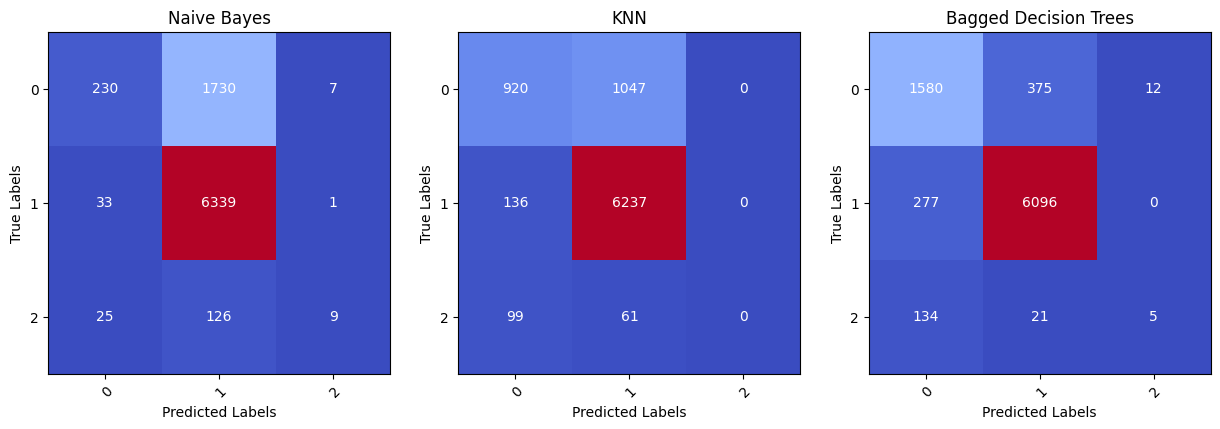

In [118]:
# Define the label encoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Creates cheat-sheet of  pitches and corresponding value after being encoded
outcomes = pd.DataFrame()
outcomes['Hit Type'] = label_encoder.inverse_transform(list(set(y)))
outcomes['Encoded'] = list(set(y))

print(outcomes, '\n')

# Define the classifiers
classifiers = [
    ('Naive Bayes', CalibratedClassifierCV(GaussianNB(), cv=3, method='isotonic')),
    ('KNN', CalibratedClassifierCV(KNeighborsClassifier(), cv=3, method='isotonic')),
    ('Bagged Decision Trees', BaggingClassifier(n_estimators=100))
]

# Define the metrics
metrics = {
    'Precision': precision_score,
    'Recall': recall_score,
    'F1-Score': f1_score,
    'ROC-AUC': roc_auc_score,
    "Cohen's Kappa": cohen_kappa_score,
    'Recall, double': None,
    'Recall, single': None,
    'Recall, triple': None
}

# Create an empty DataFrame to store the metrics
results_df = pd.DataFrame(columns=list(metrics.keys()))

# Define the column transformer for different scalers
minmax_features = ['game_week', 'launch_speed', 'angle']
standardscale_features = ['launch_angle', 'calc_distance', 'sprint_speed']
categorical_features = ['home_team']

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', StandardScaler(), standardscale_features),           # Use StandardScaler for numeric features
        ('minmax', MinMaxScaler(), minmax_features),              # Use MinMaxScaler for numeric features
        ('categorical', OneHotEncoder(sparse=False), categorical_features)     # Use OneHotEncoder for categorical features
    ])

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=69)

# Create a figure to hold the confusion matrices
fig, axes = plt.subplots(nrows=1, ncols=len(classifiers), figsize=(15, 5))

classes = np.unique(y_train)

# Iterate over classifiers
for name, classifier in classifiers:
    # Create the pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    
    #print(name, classifier)
    # Evaluate the pipeline using cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')

    # Train the pipeline
    pipeline.fit(X_train, y_train)

    
    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)

    # Calculate and store the metrics for the classifier
    results = {}

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    ax = axes[classifiers.index((name, classifier))]
    im = ax.imshow(cm, cmap=plt.cm.coolwarm)
    ax.set_title(name)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Display values in each cell of the confusion matrix
    for i in range(len(classes)):
        for j in range(len(classes)):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="white")

    for metric_name, metric_func in metrics.items():
        if metric_name in ['Precision', 'Recall', 'F1-Score']:
            metric_value = metric_func(y_test, y_pred, average='weighted')
        elif metric_name == 'ROC-AUC':
          metric_value = metric_func(y_test, y_pred_proba, average = 'weighted', multi_class = 'ovr')
        elif metric_name == "Cohen's Kappa":
          metric_value = metric_func(y_test, y_pred)
        
        results[metric_name] = metric_value
    
    # Get classification report
    report = classification_report(y_test, y_pred, output_dict=True)

    # Extract precision values from the report
    class_names = list(report.keys())
    class_names.remove('accuracy') # Remove 'accuracy' from class names
    class_names.remove('macro avg') # Remove 'macro avg' from class names
    class_names.remove('weighted avg') # Remove 'weighted avg' from class names

    for class_name in class_names:
      results[f'Recall, {label_encoder.inverse_transform([int(class_name)])[0]}'] = report[class_name]['recall']

    # Add the results to the DataFrame
    results_df.loc[name] = pd.Series(results)

# Print the results
results_df

In [116]:
report

{'0': {'precision': 0.7904430064708811,
  'recall': 0.8073207930859176,
  'f1-score': 0.7987927565392355,
  'support': 1967},
 '1': {'precision': 0.9400864731315627,
  'recall': 0.9552800878707045,
  'f1-score': 0.9476223830648299,
  'support': 6373},
 '2': {'precision': 0.3333333333333333,
  'recall': 0.03125,
  'f1-score': 0.05714285714285714,
  'support': 160},
 'accuracy': 0.9036470588235294,
 'macro avg': {'precision': 0.6879542709785924,
  'recall': 0.5979502936522074,
  'f1-score': 0.6011859989156408,
  'support': 8500},
 'weighted avg': {'precision': 0.8940359788622358,
  'recall': 0.9036470588235294,
  'f1-score': 0.8964194890032582,
  'support': 8500}}